In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
train_data = pd.read_csv('C:/Users/ccrgo/Documents/Favorito Store/train.csv')
test_data = pd.read_csv('C:/Users/ccrgo/Documents/Favorito Store/test.csv')

In [3]:
combined_data = pd.concat([train_data, test_data], axis=0)

# Data preprocessing
combined_data['date'] = pd.to_datetime(combined_data['date'])



In [4]:
# Feature engineering
combined_data['day_of_week'] = combined_data['date'].dt.dayofweek
combined_data['month'] = combined_data['date'].dt.month
combined_data['year'] = combined_data['date'].dt.year

In [5]:
lags = [7, 14, 28]
for lag in lags:
    combined_data[f'sales_lag_{lag}'] = combined_data.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    combined_data[f'sales_rolling_mean_{lag}'] = combined_data.groupby(['store_nbr', 'family'])[f'sales_lag_{lag}'].transform(lambda x: x.rolling(window=7).mean())



In [6]:
# Create dummy variables for 'store_nbr' and 'family' columns
combined_data = pd.get_dummies(combined_data, columns=['store_nbr', 'family'])

# Separate the train_data and test_data after feature engineering
train_data = combined_data[~combined_data['sales'].isna()]
test_data = combined_data[combined_data['sales'].isna()]

I notice special characters on the names so we clean it 

In [7]:
def clean_feature_names(data):
    """
    Clean special characters from feature names
    """
    return data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

# Clean feature names in train_data and test_data
train_data = clean_feature_names(train_data)
test_data = clean_feature_names(test_data)

In [8]:
# Split the dataset into training and validation sets
train, val = train_test_split(train_data, test_size=0.2, shuffle=False)

# Prepare datasets for LightGBM
features = [col for col in train.columns if col not in ['id', 'date', 'sales']]
target = 'sales'

train_dataset = lgb.Dataset(train[features], train[target])
val_dataset = lgb.Dataset(val[features], val[target], reference=train_dataset)

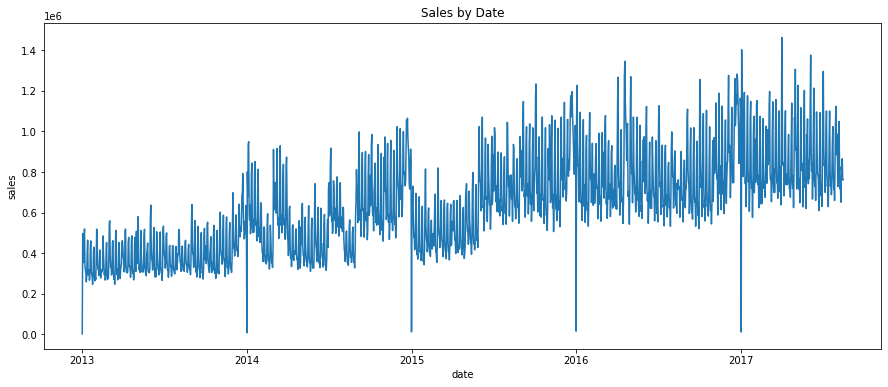

In [9]:
# Aggregate sales data by date
sales_by_date = train_data.groupby('date')['sales'].sum().reset_index()

# Plot the sales data
plt.figure(figsize=(15, 6))
sns.lineplot(data=sales_by_date, x='date', y='sales')
plt.title('Sales by Date')
plt.show()

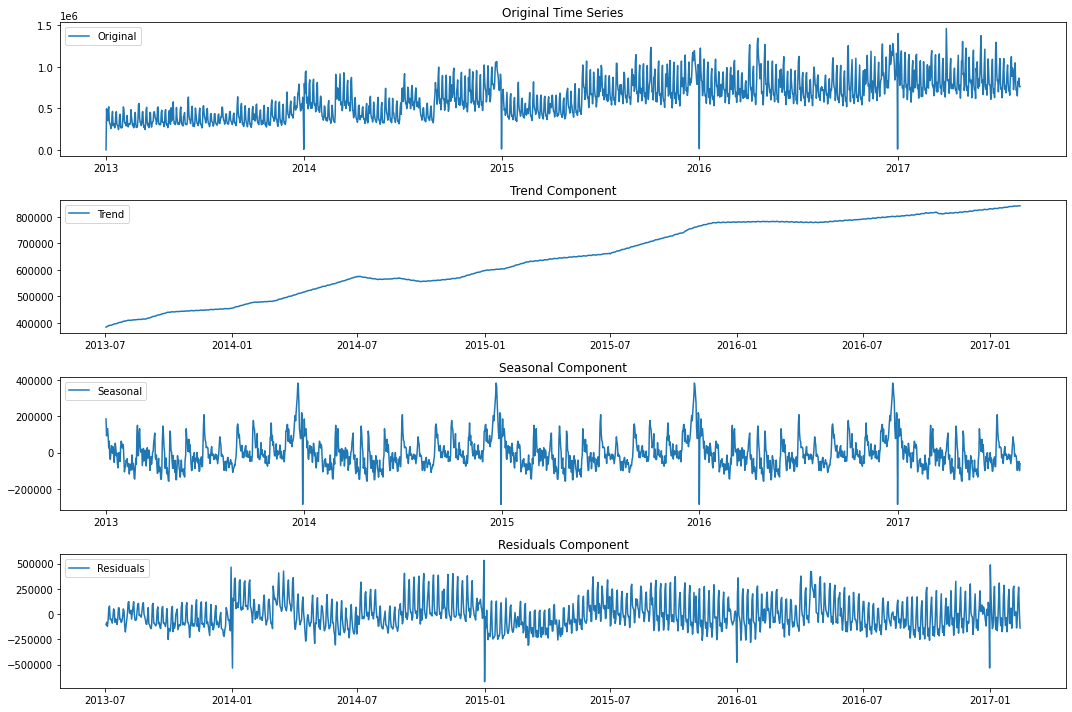

In [10]:
sales_by_date['date'] = pd.to_datetime(sales_by_date['date'])
sales_by_date.set_index('date', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_by_date['sales'], model='additive', period=365)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, trend, seasonal, and residual components
plt.figure(figsize=(15, 10))

plt.subplot(411)
plt.plot(sales_by_date, label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.title('Residuals Component')

plt.tight_layout()
plt.show()

In [11]:


# LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.005,
    'feature_fraction': 0.9
}

In [12]:
# Train the LightGBM model
model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[train_dataset, val_dataset], early_stopping_rounds=10, verbose_eval=10)


c:\Users\ccrgo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ccrgo\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1914
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 97
[LightGBM] [Info] Start training from score 328.239435
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 980.167	valid_1's rmse: 1309.28
[20]	training's rmse: 937.811	valid_1's rmse: 1252.3
[30]	training's rmse: 897.776	valid_1's rmse: 1198.48
[40]	training's rmse: 859.835	valid_1's rmse: 1147.5
[50]	training's rmse: 823.959	valid_1's rmse: 1099.17
[60]	training's rmse: 790.102	valid_1's rmse: 1053.72
[70]	training's rmse: 758.094	valid_1's rmse: 1010.67
[80]	training's rmse: 727.975	valid_1's rmse: 969.966
[90]	training's rmse: 699.493	valid_1's rmse: 931.457
[100]	training's rmse: 672.601	valid_1's r

In [13]:
# Make predictions on the validation set
val_pred = model.predict(val[features], num_iteration=model.best_iteration)


In [14]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(val[target], val_pred))
mae = mean_absolute_error(val[target], val_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 349.2395
MAE: 82.3828


In [15]:
# Make predictions on the test dataset
test_pred = model.predict(test_data[features], num_iteration=model.best_iteration)


In [19]:
test_pred_df = pd.DataFrame(test_pred, columns=['sales'])
output_df = test_data[['id']].join(test_pred_df)



In [20]:

output_df.to_csv('C:/Users/ccrgo/Documents/Favorito Store/submission.csv', index=False)

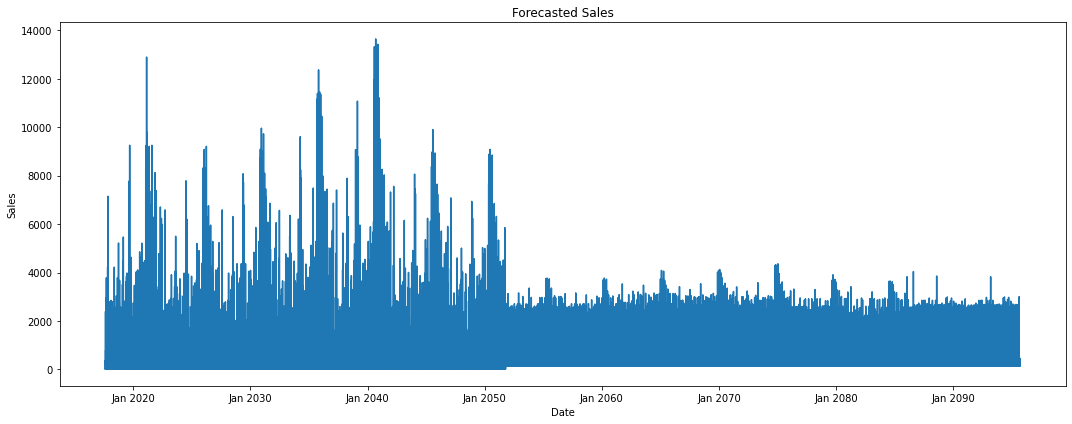

In [89]:
start_date = '2017-08-16'
periods = len(test_pred)
date_range = pd.date_range(start=start_date, periods=periods, freq='D')
forecasted_sales = pd.DataFrame({'date': date_range, 'sales': test_pred})

# Plot the forecasted sales
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=forecasted_sales, x='date', y='sales', ax=ax)

ax.set_title('Forecasted Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.tight_layout()
plt.show()


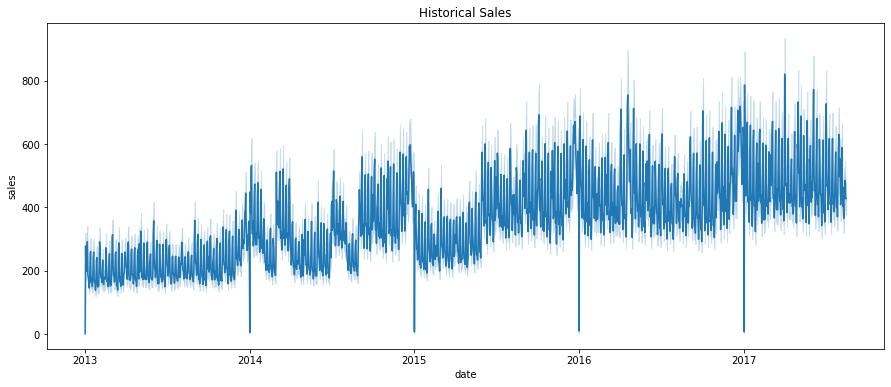

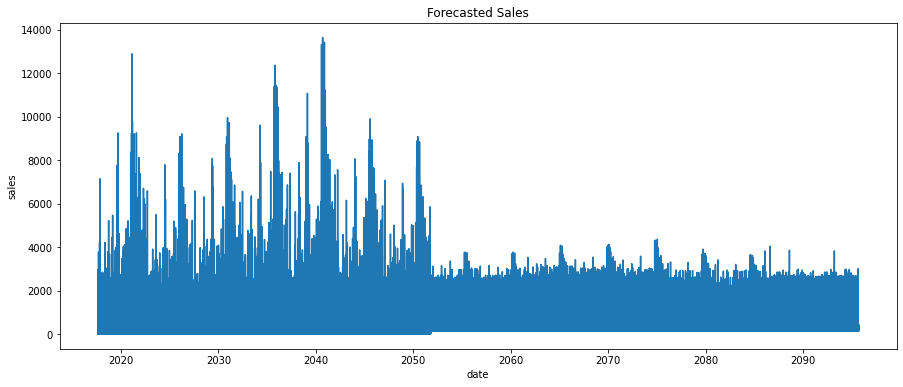

In [93]:
# Find the last date in the historical data
last_date = train_data['date'].max()

# Calculate the start date for the forecasted data (one day after the last historical date)
start_date = last_date + pd.DateOffset(days=1)

# Create the date range for the forecasted data
periods = len(test_pred)
date_range = pd.date_range(start=start_date, periods=periods, freq='D')

# Create a new DataFrame with forecasted sales
forecasted_sales = pd.DataFrame({'date': date_range, 'sales': test_pred})

# Plot historical sales
plt.figure(figsize=(15, 6))
sns.lineplot(data=historical_sales, x='date', y='sales')
plt.title('Historical Sales')
plt.show()

# Plot forecasted sales
plt.figure(figsize=(15, 6))
sns.lineplot(data=forecasted_sales, x='date', y='sales')
plt.title('Forecasted Sales')
plt.show()
